# <center> Stroke Prediction - Final Notebook
## <center> Notebook Overview
Here be the overview of what this notebook entails.

## <center> Executive Summary
Here be the executive summary of the work done in this notebook.
    
## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

import prepare

# <center> 1. Wrangle
## Wrangle Overview
1. Acquired dataset from Kaggle
1. Dropped outliers in BMI and gender columns
1. Renamed columns, cast columns to appropriate data types, dropped unnecessary columns
1. Imputed nulls in BMI column using average BMI for age range and gender
1. Plotted univariate distributions to check work
1. Noticed class imbalance and need for SMOTE+Tomek resampling
1. Encoded categorical columns identified from univariate distributions
1. Converted ordinal values from 1s and 0s to True and False values from univariate distributions
1. Created bmi_range column for BMI grouping from univariate distributions
1. Created high_glucose feature based on Explore analysis
1. Created is_senior feature based on Explore analysis
1. Split data into Train, Validate, and Test splits

## Cleaning the Data
First up, we need to clean the dataset for exploration. The specific steps are described above. These steps were put to a function in prepare.py, which we call in the following cell.

In [2]:
# Use the prep_data function to prepare the data
df = prepare.prep_data(pd.read_csv('healthcare-dataset-stroke-data.csv'))

# Check results
print(f'Shape: {df.shape[0]} rows, {df.shape[1]} columns.')
df.head(3)

Shape: 5108 rows, 12 columns.


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_range
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.6,never smoked,1,60-65
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,75-80


## Univariate Distribution Plots
Here, we will check to make sure our distributions look okay. 

------------------------------   gender   ------------------------------


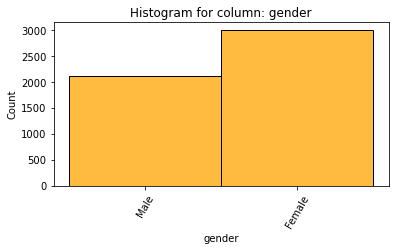

------------------------------   age   ------------------------------


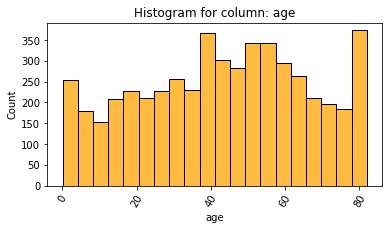

------------------------------   hypertension   ------------------------------


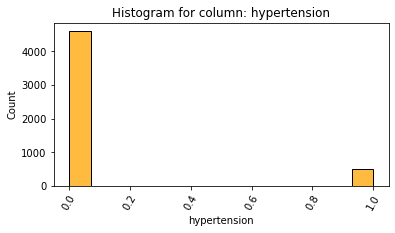

------------------------------   heart_disease   ------------------------------


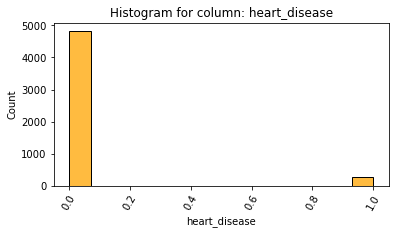

------------------------------   ever_married   ------------------------------


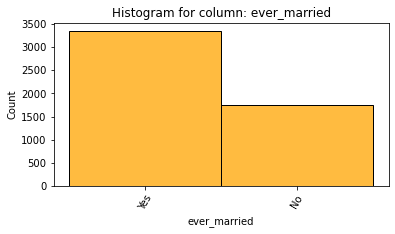

------------------------------   work_type   ------------------------------


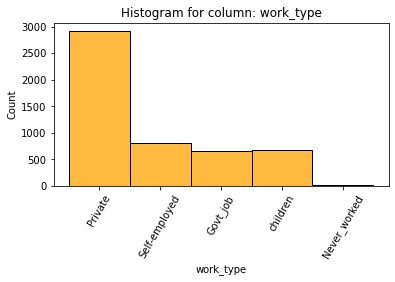

------------------------------   residence_type   ------------------------------


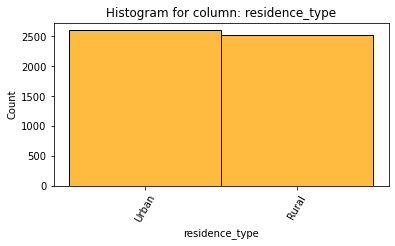

------------------------------   avg_glucose_level   ------------------------------


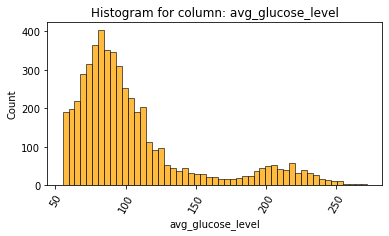

------------------------------   bmi   ------------------------------


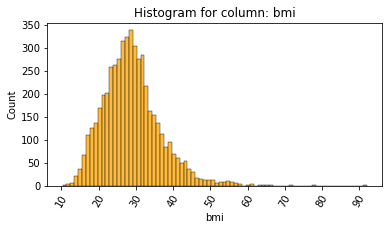

------------------------------   smoking_status   ------------------------------


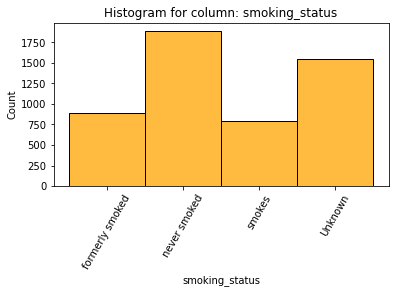

------------------------------   stroke   ------------------------------


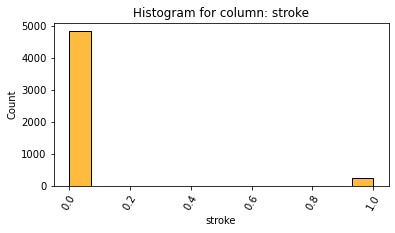

------------------------------   age_range   ------------------------------


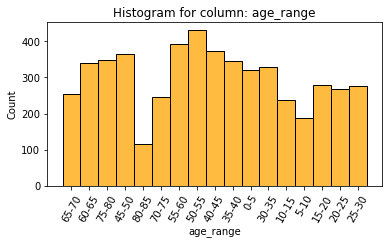

In [3]:
# Plot univariate distributions for each column
for col in df.columns:
    plt.figure(figsize=(6,3))
    print('-'*30, ' ', col, ' ', '-'*30) # use a line separator charts
    sns.histplot(df[col], color='orange')
    plt.title('Histogram for column: ' + col)
    plt.xticks(rotation=60)
    plt.show()

## Need for SMOTE + Tomek Oversampling
Our target is imbalanced, as can be seen below. We will need to use SMOTE + Tomek Oversampling later on in the Modeling section to train our classification models with balanced classes.

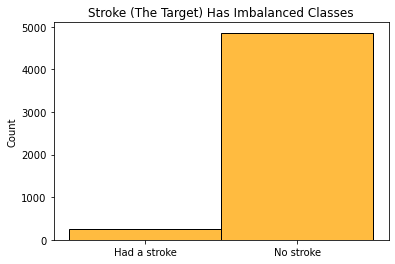

In [4]:
# Plot histogram showing class imbalance in 'stroke' column
sns.histplot(np.where(df.stroke == 1, 'Had a stroke', 'No stroke'), color='orange')
plt.title('Stroke (The Target) Has Imbalanced Classes')
plt.show()

## Feature Engineering
From these univariate distributions, we've decided to modify some features for exploration purposes. We've also incorporated some feature engineering based on analysis done in the Explore stage. This work is captured by the engineer_features function in prepare.py. 

Note: *We've combined the 'children' work type and the 'Never_worked' work type because there was overlap for those under 18 years old having the latter work type.* All other features are simply encoded or have additional columns with categorization.

In [5]:
# engineer features
engineered_df = prepare.engineer_features(df)

Original shape: 5108 rows, 12 columns.
New shape: 5108 rows, 20 columns.


In [6]:
# check results
engineered_df.head(3)

,stroke,age,age_range,is_senior,bmi,bmi_range,avg_glucose_level,high_glucose,has_hypertension,has_heart_disease,ever_married,is_female,is_urban,current_smoker,prior_smoker,never_smoked,govt_job,self_employed,private_work,never_worked
0,True,67.0,65-70,True,36.6,30-39,228.69,True,False,True,True,False,True,False,True,False,False,False,True,False
1,True,61.0,60-65,True,30.6,30-39,202.21,True,False,False,True,True,False,False,False,True,False,True,False,False
2,True,80.0,75-80,True,32.5,30-39,105.92,False,False,True,True,False,False,False,False,True,False,False,True,False


## Split data for Exploration
In order to explore on in-sample data, we will split our dataset into in-sample data and out-of-sample data. We will use the two out-of-sample splits for modeling purposes. Our splits are 60% in-sample and 20% for each out-of-sample split.

In [7]:
# Split data 60-20-20 into Train, Validate, and Test splits
train_validate, test = train_test_split(engineered_df, test_size=0.2, random_state=777)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=777)

print(f'Train shape: {train.shape}, Validate shape: {validate.shape}, Test shape: {test.shape}')
print('Row count of original dataset:', df.shape[0])
print('Row count of combined data splits:', train.shape[0] + validate.shape[0] + test.shape[0])

Train shape: (3064, 20), Validate shape: (1022, 20), Test shape: (1022, 20)
Row count of original dataset: 5108
Row count of combined data splits: 5108


## Wrangle Summary
- Cleaned the dataset
- Checked distributions, noticed class imbalance
- Engineered features in preparation for exploration
- Split data

# <center>2. Explore
## Exploration Overview
1. Checked distributions against the target, 'stroke'
1. Tested initial hypotheses
1. 

## Initial Hypotheses
### Hypothesis 1: There is relationship between average glucose level and BMI.
> - $H_0$ : There is no relationship between average glucose level and BMI.
> - $H_a$ : There is relationship between average glucose level and BMI.
> - Confidence interval is 95%

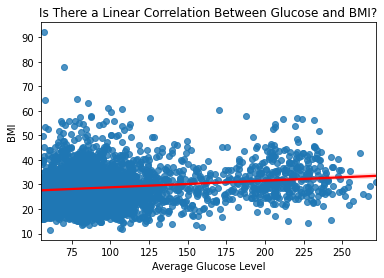

In [8]:
# visualize: use regression plot to check linear trend
sns.regplot(data=train, x="avg_glucose_level", y="bmi", line_kws={'color': 'red'})
plt.title('Is There a Linear Correlation Between Glucose and BMI?')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.show()

In [9]:
# test: set alpha for test
alpha = .05
# conduct pearson r test 
corr, p = stats.pearsonr(train.avg_glucose_level, train.bmi)
# output results
if p < alpha:
    print('We are 95% confident that there is a relationship between average glucose level and BMI.')
else:
    print('We can not say with 95% confidence that there is a realionship between average glucose level and BMI.')

We are 95% confident that there is a relationship between average glucose level and BMI.


### Hypothesis 2: People over 65 years old are more likely to have a stroke than people under 65.
> - $H_0$ : People over 65 years old are not more likely to have a stroke than people under 65.
> - $H_a$ : People over 65 years old are more likely to have a stroke than people under 65.
> - Confidence interval is 95%

In [10]:
# prepare: create samples based on age over or under 65
over_65 = train[train.age >= 65]
under_65 = train[train.age < 65]

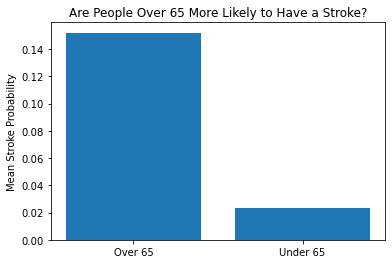

In [11]:
# visualize: plot sample means for stroke
heights = [round(over_65.stroke.mean(), 3), round(under_65.stroke.mean(), 3)]
x_labels = ['Over 65', 'Under 65']
plt.bar(x=x_labels, height=heights)
plt.title('Are People Over 65 More Likely to Have a Stroke?')
plt.ylabel("Mean Stroke Probability")
plt.show()

In [12]:
# test: set alpha
alpha = .05
# conduct mannwhitney u test
t, p = stats.mannwhitneyu(over_65.stroke, under_65.stroke, alternative='greater')
# output results
if p < alpha and t > 0:
    print('We are 95% confident that people over 65 years old are more likely to have a stroke than people under 65.')
else:
    print('We can not say with 95% confidence that people over 65 years old are not more likely to have a stroke than people under 65.')

We are 95% confident that people over 65 years old are more likely to have a stroke than people under 65.


### Hypothesis 3: People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - $H_0$ : People that currently smoke do not have a higher risk of stroke than people that don’t currently smoke.
> - $H_a$ : People that currently smoke have a higher risk of stroke than people that don’t currently smoke.
> - Confidence interval is 95%

In [13]:
# prepare: create samples for current smokers and those who are not currently smoking
active_smoker = train[train.current_smoker == "True"]
not_active_smoker = train[train.current_smoker == "False"]

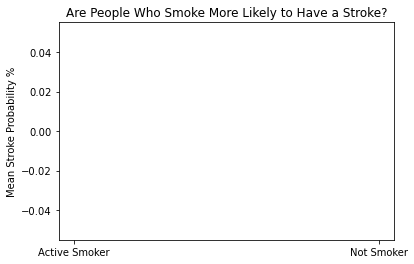

In [14]:
# visualize: plot sample means for stroke
heights = [round(active_smoker.stroke.mean(), 3), round(not_active_smoker.stroke.mean(), 3)]
x_labels = ['Active Smoker', 'Not Smoker']
plt.bar(x=x_labels, height=heights)
plt.title('Are People Who Smoke More Likely to Have a Stroke?')
plt.ylabel("Mean Stroke Probability %")
plt.show()

In [15]:
# test: set alpha
alpha = .05
# run mannwhitney u test
t, p = stats.mannwhitneyu(active_smoker.stroke, not_active_smoker.stroke, alternative='greater')
# output results
if p < alpha and t > 0:
    print('People that currently smoke have a higher risk of stroke than people that don’t currently smoke.')
else:
    print('We can not say with 95% confidence that people who currently smoke have a higher risk of stroke than people who don’t currently smoke.')

We can not say with 95% confidence that people who currently smoke have a higher risk of stroke than people who don’t currently smoke.


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:7171: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


### Hypothesis 4: Men are more at risk for stroke than women.
> - $H_0$ : Men are not more at risk for stroke than women.
> - $H_a$ : Men are more at risk for stroke than women.
> - Confidence interval is 95%

In [16]:
# prepare: create samples for men and women
men = train[train.is_female == "False"]
women = train[train.is_female == "True"]

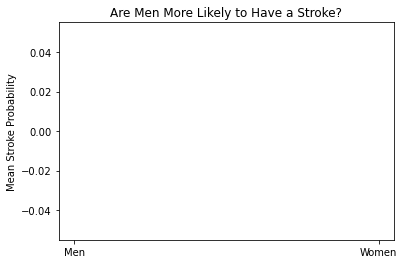

In [17]:
# visualize: plot sample means for stroke
heights = [round(men.stroke.mean(), 3), round(women.stroke.mean(), 3)]
x_labels = ['Men', 'Women']
plt.bar(x=x_labels, height=heights)
plt.title('Are Men More Likely to Have a Stroke?')
plt.ylabel("Mean Stroke Probability")
plt.show()

In [18]:
# test: set alpha
alpha = .05
# run mannwhitney u test
t, p = stats.mannwhitneyu(men.stroke, women.stroke, alternative='greater')
# output results
if p < alpha and t > 0:
    print('We are 95% confident that men are more at risk for stroke than women.')
else:
    print('We can not say with 95% confidence that men are more at risk for stroke than women.')

We can not say with 95% confidence that men are more at risk for stroke than women.


### Initial Hypotheses - Combined Results
> #### We are 95% confident that there is a relationship between average glucose level and BMI.
> #### We are 95% confident that people over 65 years old are more likely to have a stroke than people under 65.
> #### We can not say with 95% confidence that people who currently smoke have a higher risk of stroke than people who don’t currently smoke.
> #### We can not say with 95% confidence that men are more at risk for stroke than women.

# Further Exploration
## Stats Tests - from combination of team members' notebook work
* Explain statistical tests to check if features are driving stroke occurence
* Independence (Chi2) tests between features and target
* T-Tests to check drivers
* Sample vizs to explain process
* Actual vizs on their own (limiting redundancy of explanation)

## Initial Bivariate Visualizations
* Show how age is distributed differently between had_stroke and no_stroke
    * Explain potential effect of age column on other features

-------------------- age --------------------


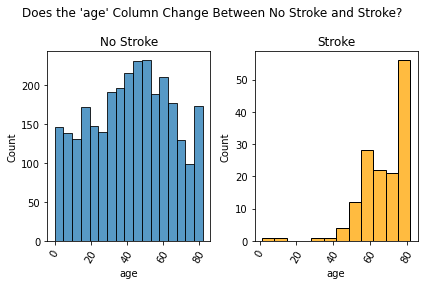

Mean value of age between had-stroke and no-stroke is significantly different.

-------------------- is_senior --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


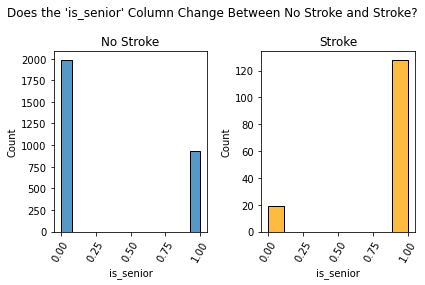

Mean value of is_senior between had-stroke and no-stroke is significantly different.

-------------------- bmi --------------------


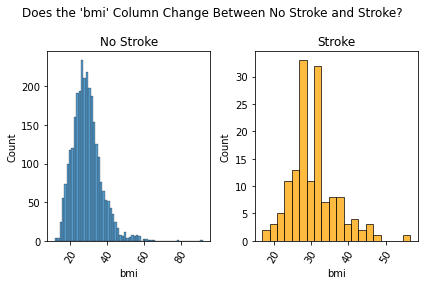

Mean value of bmi between had-stroke and no-stroke is significantly different.

-------------------- avg_glucose_level --------------------


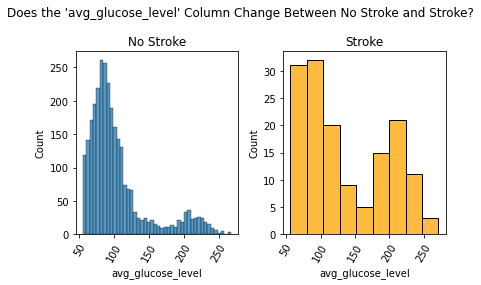

Mean value of avg_glucose_level between had-stroke and no-stroke is significantly different.

-------------------- high_glucose --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


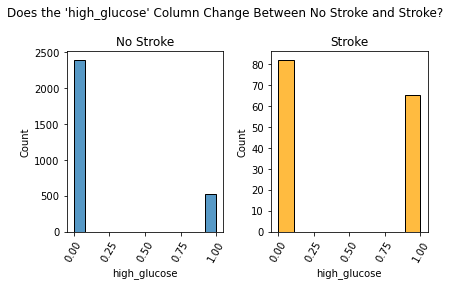

Mean value of high_glucose between had-stroke and no-stroke is significantly different.

-------------------- has_hypertension --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


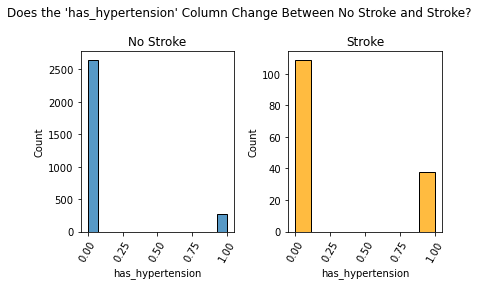

Mean value of has_hypertension between had-stroke and no-stroke is significantly different.

-------------------- has_heart_disease --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


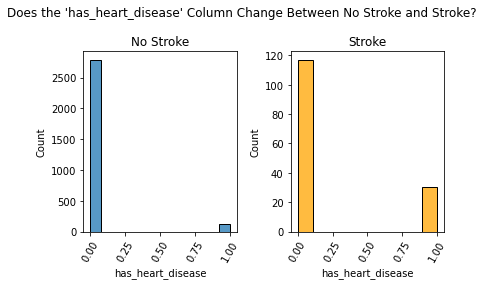

Mean value of has_heart_disease between had-stroke and no-stroke is significantly different.

-------------------- ever_married --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


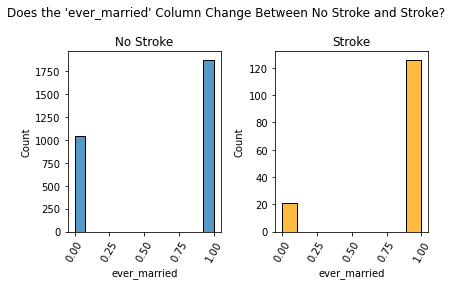

Mean value of ever_married between had-stroke and no-stroke is significantly different.

-------------------- is_female --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


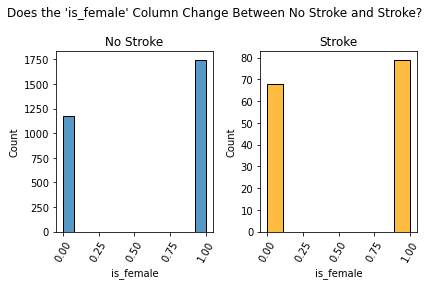

Mean value of is_female between had-stroke and no-stroke is not significantly different.

-------------------- is_urban --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


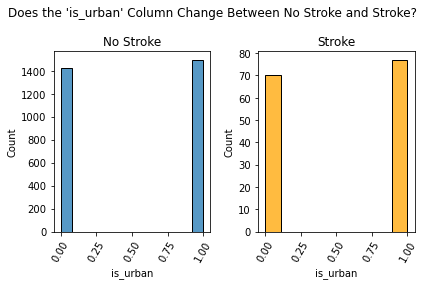

Mean value of is_urban between had-stroke and no-stroke is not significantly different.

-------------------- current_smoker --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


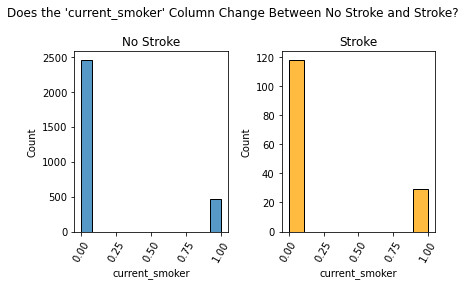

Mean value of current_smoker between had-stroke and no-stroke is not significantly different.

-------------------- prior_smoker --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


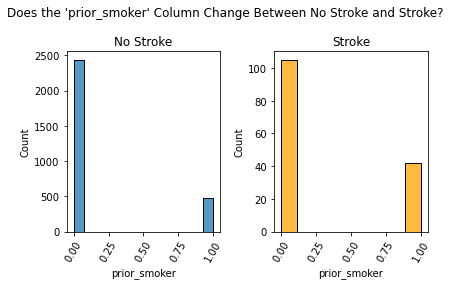

Mean value of prior_smoker between had-stroke and no-stroke is significantly different.

-------------------- never_smoked --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


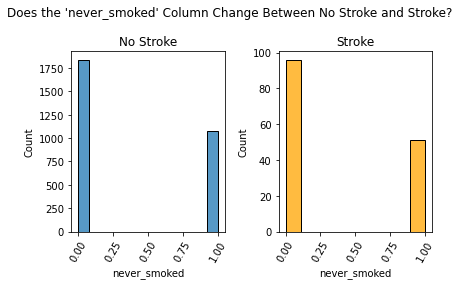

Mean value of never_smoked between had-stroke and no-stroke is not significantly different.

-------------------- govt_job --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


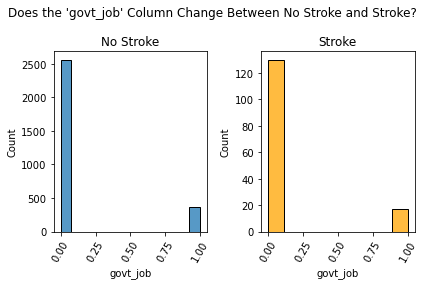

Mean value of govt_job between had-stroke and no-stroke is not significantly different.

-------------------- self_employed --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


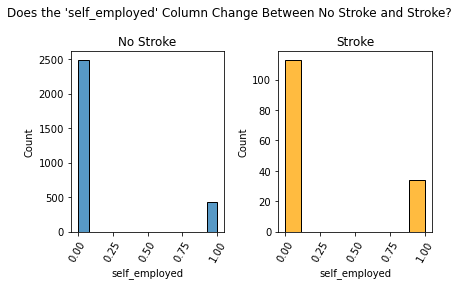

Mean value of self_employed between had-stroke and no-stroke is significantly different.

-------------------- private_work --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


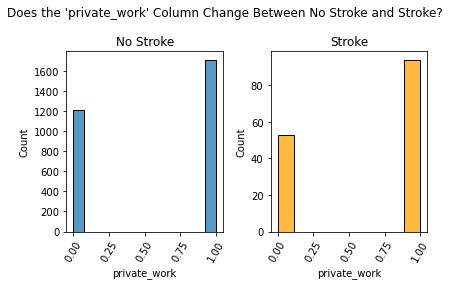

Mean value of private_work between had-stroke and no-stroke is not significantly different.

-------------------- never_worked --------------------


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


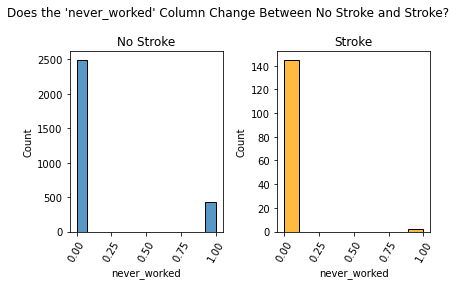

Mean value of never_worked between had-stroke and no-stroke is significantly different.



In [19]:
# initial chart look (looking for differences between left chart and right chart for each)
col_list_to_drop = ['age_range','bmi_range']
for col in train.drop(columns=col_list_to_drop).columns[1:]:
    print('-'*20, col, '-'*20)
    # visualization
    plt.subplot(121) # Observations without stroke (left charts)
    plt.title('No Stroke')
    sns.histplot(train[train.stroke == 0][col].sort_values(ascending=False))
    plt.xticks(rotation=60)
    plt.subplot(122) # Observations with stroke (right charts)
    plt.title('Stroke')
    sns.histplot(train[train.stroke == 1][col].sort_values(ascending=False), color='orange')
    plt.xticks(rotation=60)
    plt.suptitle("Does the '" + col + "' Column Change Between No Stroke and Stroke?")
    plt.tight_layout()
    plt.show()
    # statistical test
    t, p = stats.mannwhitneyu(train[train.stroke == 1][col], 
                              train[train.stroke == 0][col],
                              alternative='two-sided')
    if t != 0 and p < .025:
        print(f"Mean value of {col} between had-stroke and no-stroke is significantly different.")
        print('')
    else:
        print(f"Mean value of {col} between had-stroke and no-stroke is not significantly different.")
        print('')

## Results of Bivariate Visualizations
Keepers:
- age
- is_senior
- bmi
- avg_glucose_level
- high_glucose
- has_hypertension
- has_heart_disease
- prior_smoker
- self_employed
- never_worked

Remove:
- is_female
- is_urban
- current_smoker
- never_smoked
- govt_job
- private_work

In [20]:
train = train.drop(columns=['is_female','is_urban','current_smoker','never_smoked',
                            'govt_job','private_work'])

## Age May Drive Other Features
The 'age' column has a significant difference in distribution between no-stroke and stroke. The team suspects that **age may be driving stroke occurence and also driving other features.** It's possible that some features may not drive stroke occurence- only appear to do so because they are being driven by age, which (likely) is driving stroke.

Here is a visualization showing the difference in distribution for the age column.

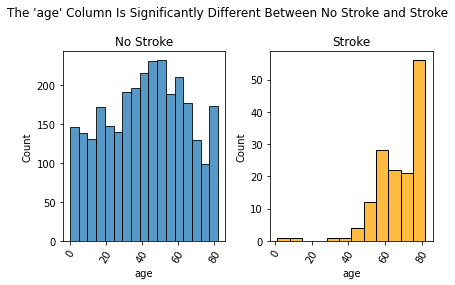

In [21]:
# show the difference in distribution for age between no stroke and stroke
plt.subplot(121) # Observations without stroke (left charts)
plt.title('No Stroke')
sns.histplot(train[train.stroke == 0]['age'].sort_values(ascending=False))
plt.xticks(rotation=60)
plt.subplot(122) # Observations with stroke (right charts)
plt.title('Stroke')
sns.histplot(train[train.stroke == 1]['age'].sort_values(ascending=False), color='orange')
plt.xticks(rotation=60)
plt.suptitle("The 'age' Column Is Significantly Different Between No Stroke and Stroke")
plt.tight_layout()
plt.show()

## Determining if Age Matters for a Feature - Categorical
### Visual Determination
To check visually if features differ regardless of age, we will use the feature 'is_senior' to split the data into two samples, then check the feature's stroke risk for its values. The implementation is in the following charts.

We're looking to see if the orange columns are both higher than the blue columns they're associated with.

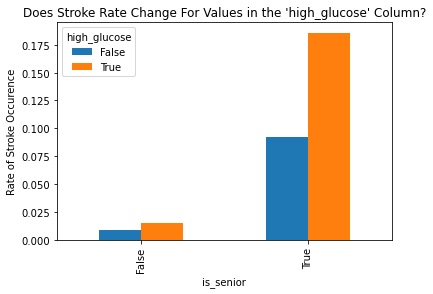

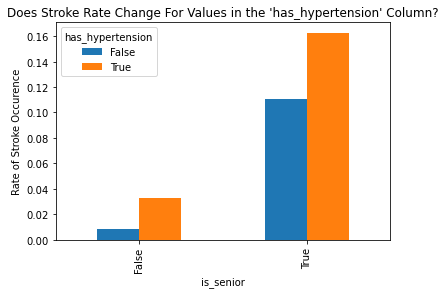

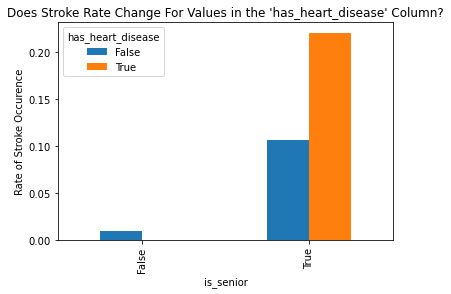

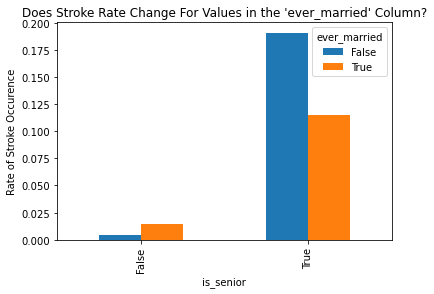

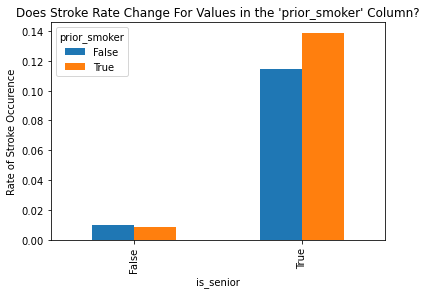

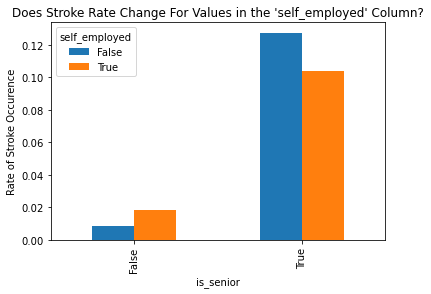

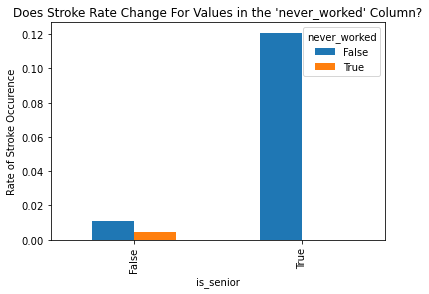

In [22]:
for col in train.columns[7:]:
    train.groupby(['is_senior',col]).stroke.mean().unstack().plot.bar()
    plt.title("Does Stroke Rate Change For Values in the '" + col + "' Column?")
    plt.ylabel('Rate of Stroke Occurence')
    plt.show()

### Visual Determination Results
- **high_glucose** increases risk of stroke (orange bars larger than blue bars), but the increase for seniors is larger, suggesting age has an influence
- **has_hypertension** increases risk of stroke (orange bars larger than blue bars), but the increase for seniors is less dramatic, suggesting younger prople with hypertension are more at risk than older
- **has_heart_disease** entirely belongs to those over age 55, suggesting it has everything to do with age.
- **ever_married** indicates a higher risk for people under 55, but a lower risk for people over 55, for those who have ever married.
- **prior_smoker** increases risk of stroke (orange bars larger than blue bars), and the increase is similar for those under or over 55, suggesting age does not have an influence.
- **self_employed**
- **never_worked**

### Statistical Determination
In order to check this statistically, we should use a Chi2 test.

In [28]:
train.head()

,stroke,age,age_range,is_senior,bmi,bmi_range,avg_glucose_level,high_glucose,has_hypertension,has_heart_disease,ever_married,prior_smoker,self_employed,never_worked
1989,False,51.0,50-55,False,31.4,30-39,145.22,True,False,False,True,False,False,False
4128,False,36.0,35-40,False,22.3,20-29,99.72,False,False,False,True,False,False,False
1961,False,53.0,50-55,False,24.7,20-29,84.85,False,False,False,True,False,True,False
38,True,58.0,55-60,True,32.0,30-39,92.62,False,False,False,False,False,False,False
3086,False,6.0,5-10,False,17.7,10-19,107.40,False,False,False,False,False,False,True


In [29]:
contigency_pct = pd.crosstab(df['high_glucose'], df['stroke'], normalize='index')
contigency_pct

stroke,False,True
high_glucose,,
False,0.963738,0.036262
True,0.899900,0.100100


<AxesSubplot:xlabel='stroke', ylabel='high_glucose'>

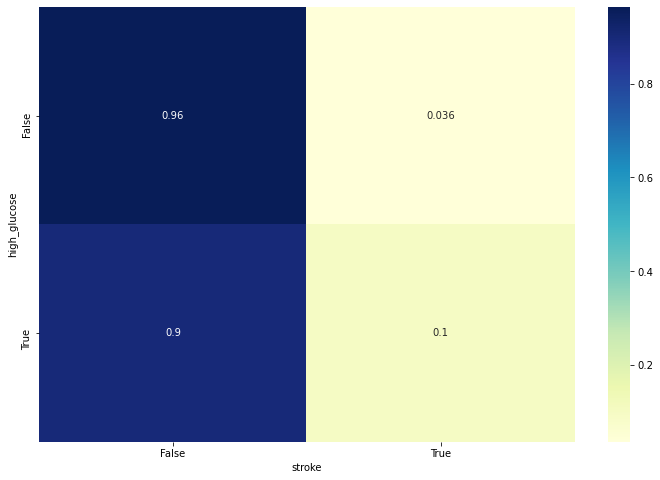

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(contigency_pct, annot=True, cmap="YlGnBu")

In [33]:
from scipy.stats import chi2_contingency
# Chi-square test of independence.
c, p, dof, expected = chi2_contingency(contigency_pct)
p   
#Rejected the null hypothesis

0.008632766537124265

In [36]:
contigency_pct = pd.crosstab(df['high_glucose'], df['is_senior'], normalize='index')
contigency_pct

is_senior,False,True
high_glucose,,
False,0.697980,0.302020
True,0.461461,0.538539


<AxesSubplot:xlabel='is_senior', ylabel='high_glucose'>

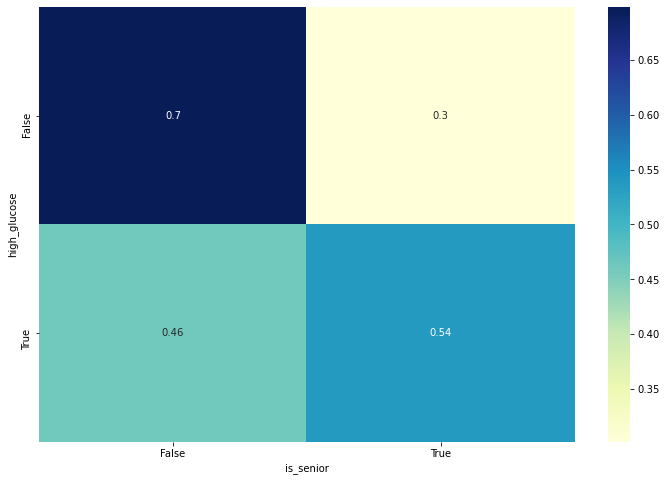

In [37]:
plt.figure(figsize=(12,8))
sns.heatmap(contigency_pct, annot=True, cmap="YlGnBu")

In [52]:
contigency_pct = pd.crosstab(df['high_glucose'], df['is_senior'], normalize='index')
contigency_pct

AttributeError: 'PrettyDict' object has no attribute 'head'

In [44]:
train

,stroke,age,age_range,is_senior,bmi,bmi_range,avg_glucose_level,high_glucose,has_hypertension,has_heart_disease,ever_married,prior_smoker,self_employed,never_worked
1989,False,51.0,50-55,False,31.4,30-39,145.22,True,False,False,True,False,False,False
4128,False,36.0,35-40,False,22.3,20-29,99.72,False,False,False,True,False,False,False
1961,False,53.0,50-55,False,24.7,20-29,84.85,False,False,False,True,False,True,False
38,True,58.0,55-60,True,32.0,30-39,92.62,False,False,False,False,False,False,False
3086,False,6.0,5-10,False,17.7,10-19,107.40,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,False,30.0,25-30,False,33.7,30-39,62.25,False,False,False,True,False,False,False
4436,False,41.0,40-45,False,28.0,20-29,60.73,False,False,False,False,False,True,False
4624,False,33.0,30-35,False,32.8,30-39,90.73,False,False,False,True,False,False,False
370,False,44.0,40-45,False,37.5,30-39,74.91,False,False,False,True,False,False,False


### Combined Results
- test 42 results:
- ...

### Results - Features Kept, Eliminated
- Indetermined driver of stroke: feature
- Determined driver of stroke: feature

# Exploration Takeaways
- Sumarize exploration here

# <center> 3. Model
## a. Modeling Overview
- Encoded features that need it
- Isolated target
- Scaled numeric data
- Applied SMOTE + Tomek oversampling to train models on balanced classes
- Built, fit multiple classification models
- Evaluated results of all models on Validate split
- Chose best model to evaluate on Test split
- Evaluated best model on Test split

## b. Building, Fitting, Evaluating Models
### Model Preparation Script - No SMOTE

In [ ]:
# use prepare.model_prep_no_smote function here

### Model Build+Fit+Predict Script - No SMOTE
- Return non-SMOTEd predictions dataframe, keep separate

In [ ]:
# use model.classification_shotgun function here to build predictions dataframe (non-SMOTEd)


### Model Preparation Script - with SMOTE

In [ ]:
# use SMOTE on the train split here - don't use the model_prep function

### Model Build+Fit+Predict Script - with SMOTE
- Return SMOTEd predictions dataframe, keep separate

In [ ]:
# use model.classification_shotgun function here to build predictions dataframe on SMOTEd data


## c. Model Performance on Train, Validate
### Model Evaluation Script - Comparing non-SMOTEd and SMOTEd Models
- Join the non-SMOTEd and SMOTEd dataframes together with column renaming to identify if model incorporated SMOTE or not
- Print evaluation results of joined dataframe as normal
- Show difference between SMOTEd and non-SMOTEd model performance

In [ ]:
# use model.print_classification_results function here to check results of all models

### ROC Curve and AUC calculation
- Explain why we're using it here

In [ ]:
# create ROC and Precision-Recall visualizations here

## Best Model's Performance on Test

In [ ]:
# evaluate best model on Test split here

### Best Model's results on Test
- Explain results here in Markdown

# Modeling Takeaways
- Summarize modeling here

# <center> 4. Risk-Calculation Program
## Risk-Calculation Program Overview

### What it aims to do
- Provide users with a score indicating stroke risk where higher numbers are higher risk
- Uses our best model to calculate the risk score

### Instructions
- Write step-by-step instructions here

## Implementation with Sample Input

In [ ]:
# call function here

# <center> Conclusion

## Conclusion
1. Note stats test takeaways
1. Note model performance
1. Explain takeaways
1. Conclude